In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
in_feature = 16
out_feature = 8
bias = True
cycle = 256

total_bit = 16
input_int_bit = 3
input_fra_bit = total_bit - input_int_bit

input = ((torch.rand(256, in_feature) - 0.5) * 2**(2*input_int_bit)).round().div(2**(input_int_bit)).to(device)

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
fc_o = fc(input)

weight_int_bit = int(math.log2(fc.weight.abs().max().item()))
weight_fra_bit = total_bit - weight_int_bit
print("input_format: ", 1, input_int_bit, input_fra_bit)
print("weight_format: ", 1, weight_int_bit, weight_fra_bit)
ufc = UnaryLinearSA(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle).to(device)
ufc_o = ufc(input)

(fc_o - ufc_o).abs().mean().backward()

input_format:  1 3 13
weight_format:  1 -2 18


diff max: tensor(0.0422, device='cuda:0', grad_fn=<MaxBackward1>)
diff min: tensor(-0.0366, device='cuda:0', grad_fn=<MinBackward1>)
diff mean: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


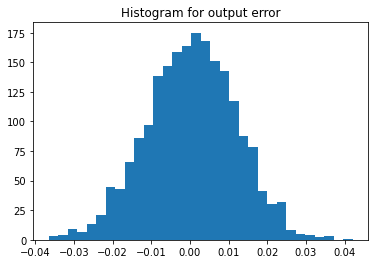

In [5]:
diff = (ufc_o - fc_o)
print("diff max:", diff.max())
print("diff min:", diff.min())
print("diff mean:", diff.mean())

fig = plt.hist(diff.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for output error")
plt.show()

diff grad max: tensor(0.2249, device='cuda:0')
diff grad min: tensor(-0.2220, device='cuda:0')
diff grad mean: tensor(0.0019, device='cuda:0')


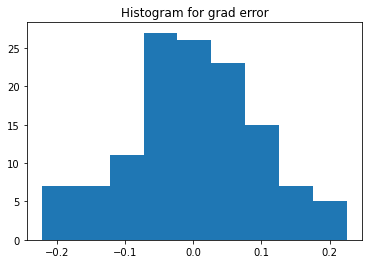

In [6]:
diff_grad = (ufc.weight.grad - fc.weight.grad)
print("diff grad max:", diff_grad.max())
print("diff grad min:", diff_grad.min())
print("diff grad mean:", diff_grad.mean())

fig = plt.hist(diff_grad.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for grad error")
plt.show()

In [7]:
print(ufc_o)

tensor([[-1.3938, -0.7525,  0.8408,  ..., -0.4775,  0.8931, -1.5578],
        [-0.4875, -0.8228,  2.0908,  ..., -0.5674,  1.0533, -1.3078],
        [ 0.1023, -0.5533, -1.4873,  ..., -1.3760,  0.5572, -1.9680],
        ...,
        [-1.5852,  0.2632,  1.6416,  ...,  2.4756,  1.7135, -0.9172],
        [-1.4290, -1.2134, -0.8116,  ..., -0.5908,  0.1431, -1.3703],
        [-0.8196, -1.8736,  0.4619,  ..., -0.6260,  0.5767, -0.9836]],
       device='cuda:0', grad_fn=<UnaryLinearSAFunctionBackward>)
